# 05 Validation
### Context
#### Cross Validation
+ The Set of Train, Valid, Test 
+ k-Fold with Stratify
+ Cross Validation Score

#### Parameter Tuning
+ Grid Search
+ Random Search

#### Ensemble
+ Voting Ensemble
+ Stacking, Average Blending

In [75]:
import os
from os.path import join
import copy
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import sklearn

import matplotlib.pyplot as plt
#어덜트 데이터 셋 미국 시민들의 직업 소득 교육수준등 인종 근무시간 나이등...4만8천개정도 소득예측 5만달러 기준 이진분류임
adult_path = join( 'adult_data.csv')
column_path = join( 'adult_names.txt')

adult_columns = list()
for l in open(column_path):
    adult_columns = l.split()

In [76]:
data = pd.read_csv(adult_path,names=adult_columns)
label = data['income']

del data['income']
data.head(2)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States


In [41]:
label

0        <=50K
1        <=50K
2        <=50K
3        <=50K
4        <=50K
         ...  
48837    <=50K
48838    <=50K
48839    <=50K
48840    <=50K
48841     >50K
Name: income, Length: 48842, dtype: object

In [77]:
data.shape

(48842, 14)

In [ ]:
data.describe()

In [ ]:
data.info()

Pandas get_dummies 함수를 사용해 범주형 변수를 One-Hot Encoding하고, 라벨 데이터를 0,1 로 변경하겠습니다. 

In [80]:
data=pd.get_dummies(data)
label= label.map(lambda x : 0 if x==">50K" else 1)

In [81]:
data.shape

(48842, 108)

In [82]:
label

0        1
1        1
2        1
3        1
4        1
        ..
48837    1
48838    1
48839    1
48840    1
48841    0
Name: income, Length: 48842, dtype: int64

In [83]:
label.sum()

37155

## Cross Validation
### 1. Train, Valid, Test Set
훈련, 검증, 테스트 데이터라고 부르는 3가지를 한번 이야기 해보겠습니다.<br>
* Train Data : 모델을 학습하는데 사용하는 데이터 (모델이 알고 있는 학습할 데이터)
* Valid Data : 학습한 모델의 성능을 검증하는 데이터 (모델이 모르는 학습하지 않을 데이터, 모델 검증에 사용하는 데이터)
* Test Data : 학습한 모델로 예측할 데이터 (모델이 모르는 예측할 데이터)

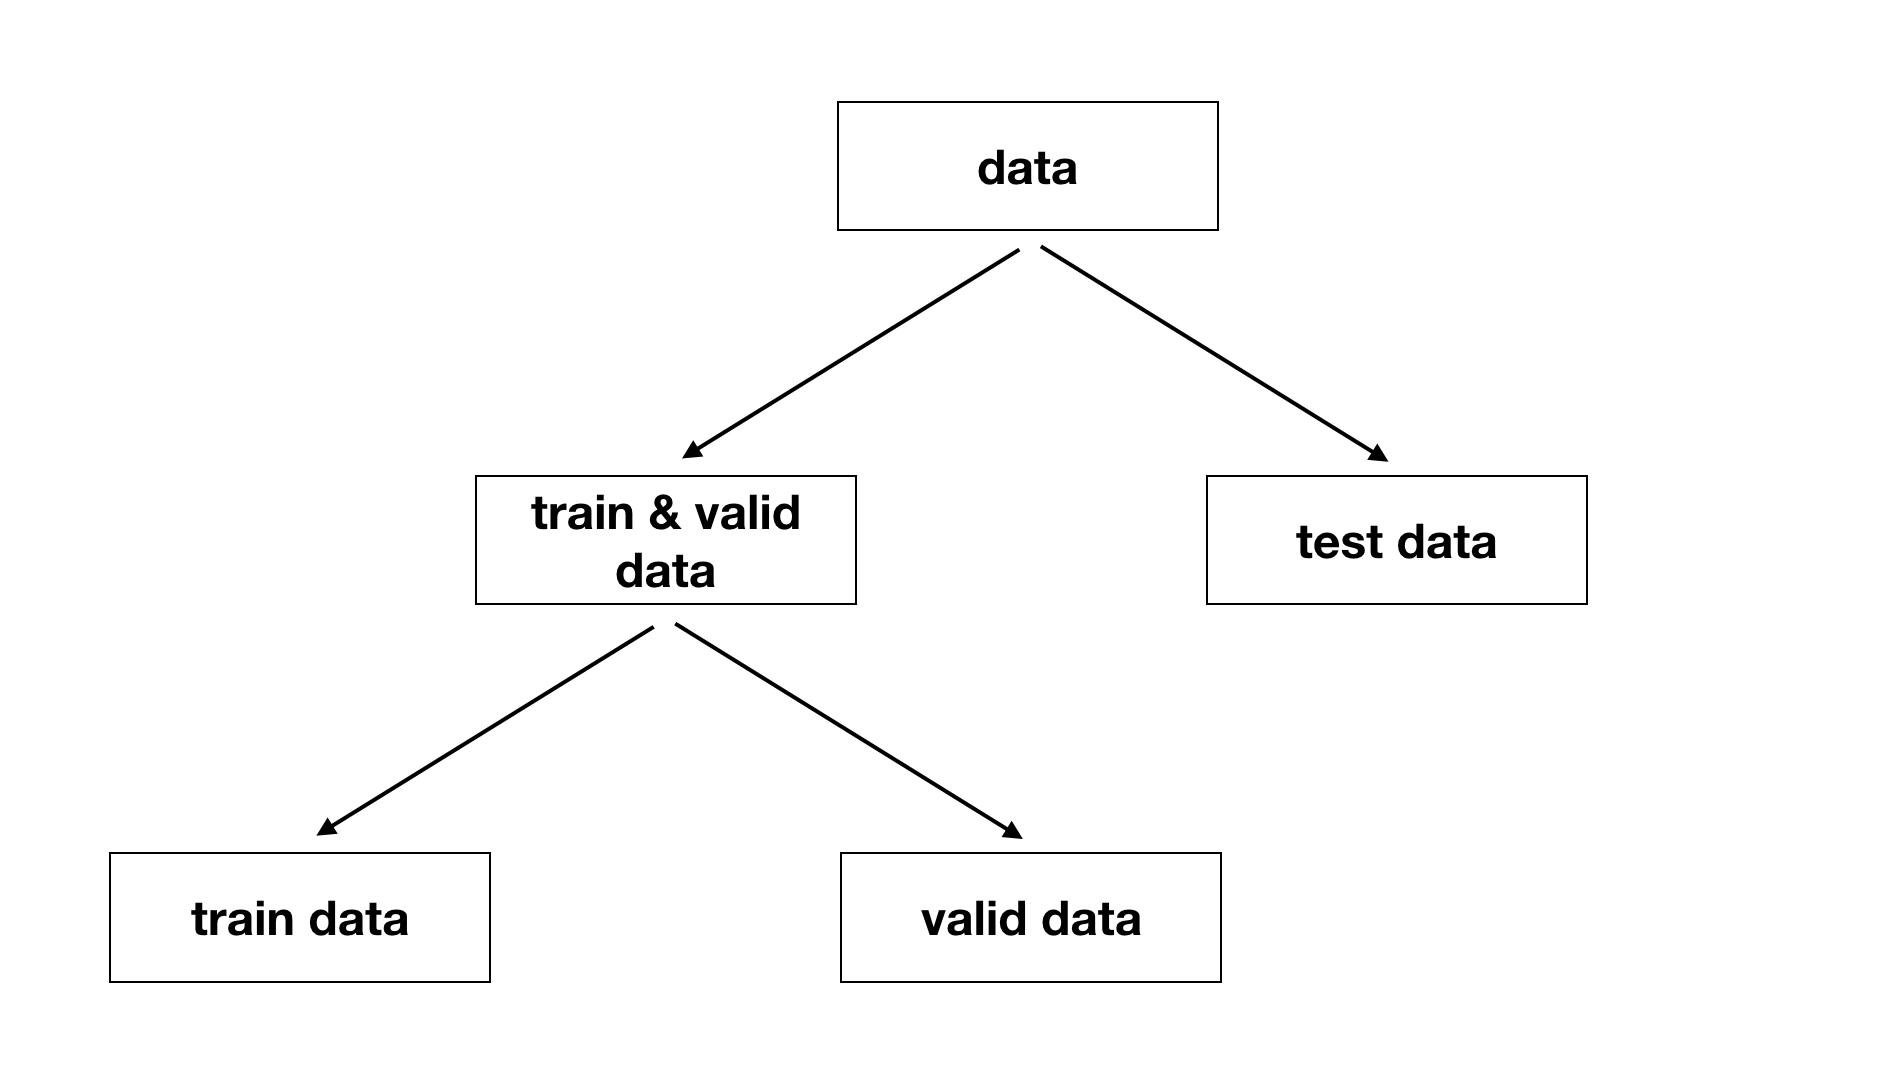


머신러닝에서 Validation 데이터가 왜 필요한지에 대한 부분은 참조 링크를 남겨두었으니 확인하시면 좋겠습니다.

In [89]:
print('ones : {:.2f}%'.format((np.sum(label==1,axis=0)/len(data))*100))
print('zeros : {:.2f}%'.format((np.sum(label==0,axis=0)/len(data))*100))
 

ones : 76.07%
zeros : 23.93%


In [91]:
from sklearn.model_selection import train_test_split
#test구분
x,x_test,y,y_test = train_test_split(data,label,test_size=0.2,stratify=label,shuffle=True)

In [92]:
#valid 구분
x_train,x_valid,y_train,y_valid = train_test_split(x,y,test_size=0.2,stratify=y,shuffle=True)

In [95]:
print('ones : {:.2f}%'.format((np.sum(y_train==1,axis=0)/len(y_train))*100))
print('zeros : {:.2f}%'.format((np.sum(y_train==0,axis=0)/len(y_train))*100))

ones : 76.07%
zeros : 23.93%


In [96]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression(random_state=2022)
 
lr.fit(x_train, y_train)

LogisticRegression(random_state=2022)

In [99]:
#valid 데이터 검증
y_pred_val = lr.predict(x_valid)
print('로지스틱 회귀 검증 데이터 정확도 :  {:.2f}%'.format(accuracy_score(y_valid,y_pred_val)*100))

로지스틱 회귀 검증 데이터 정확도 :  79.80%


In [101]:
# Test 데이터로 모델 평가
y_pred = lr.predict(x_test)
print('로지스틱 회귀 테스트 데이터 정확도 : {:.2f}%'.format(accuracy_score(y_test,y_pred)*100))

로지스틱 회귀 테스트 데이터 정확도 : 80.01%


### 2. k-fold with stratify
k-fold는 데이터를 k개로 쪼개는 것을 말합니다. <br>
일반적으로 Cross Validation에서 사용되며, 데이터셋을 k개로 쪼개어 k-1개로 모델을 학습하고, 1개로 모델을 검증합니다. <br>
k개로 데이터를 쪼개면, 모든 fold에 대해(하나의 fold를 선택하여) 검증하는 방식으로 k번 다른 데이터셋으로 학습한 모델을 검증할 수 있습니다.

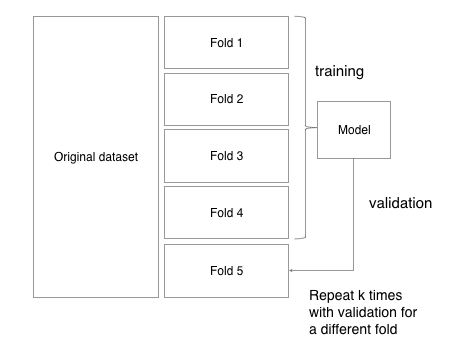

#### Stratify, 계층적 k-fold는 뭔가요?
k-fold는 데이터의 정렬 유무와 분류할 클래스의 비율에 상관없이 순서대로 데이터를 분할하는 특징이 있습니다.<br>
하지만, 분류할 클래스의 비율이 다르다면 어떻게 될까요? 그런 경우에는, 각 fold가 학습 데이터셋을 대표한다고 말하기 어려워집니다.<br>
한 fold에 특정 클래스가 많이 나올수도, 적게 나올수도 있기 때문입니다. Stratified k-fold는 그러한 문제점을 해결하기 위해 제안되었습니다.<br>
k개의 fold도 분할한 이후에도, 전체 훈련 데이터의 클래스 비율과 각 fold가 가지고 있는 클래스의 비율을 맞추어 준다는 점이 기존의 k-fold와의 다른 특징 입니다. 

##### k-fold
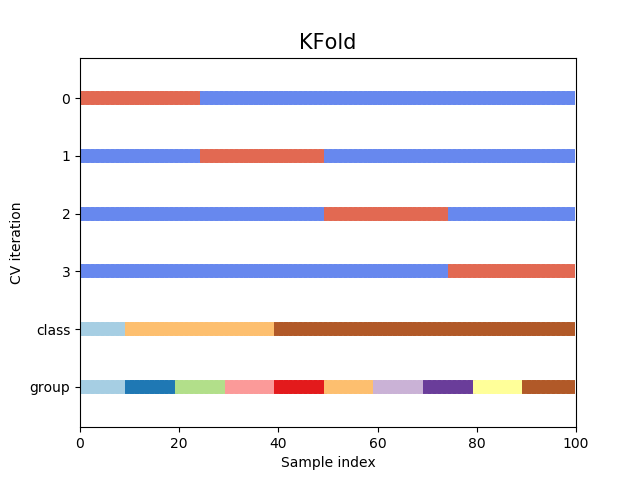

##### Stratified k-fold
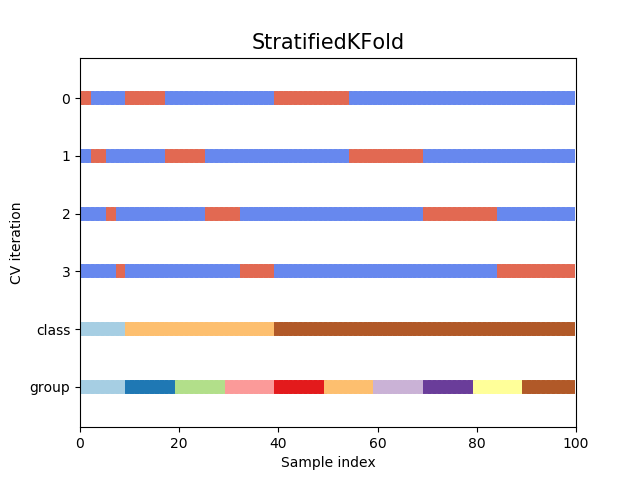


 
k-fold 실습을 위해 iris 데이터를 불러오겠습니다.

In [102]:
from sklearn.datasets import load_iris
iris = load_iris()

kf_data = iris.data
kf_label = iris.target
kf_columns = iris.feature_names

In [103]:
kf_data = pd.DataFrame(kf_data, columns = kf_columns)
kf_data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [104]:
kf_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

#### k-Fold
k-fold는 말 그대로 데이터를 k개로 쪼갭니다. <br>
k의 개수를 조절하여 몇개의 fold를 만들지 결정할 수 있습니다.

k-fold는 sklearn의 model_selection 패키지에 있습니다.

In [105]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5,shuffle=True,random_state=2022)

In [ ]:
for i, (trn_idx, val_idx) in enumerate(kf.split(kf_data.values, kf_label)):
  trn_data, trn_label = kf_data.values[trn_idx, :], kf_label[trn_idx]
  val_data, val_label = kf_data.values[val_idx, :], kf_label[val_idx]
  print('{} Fold, trn label\n{}'.format(i, trn_label))
  print('{} Fold, val label\n{}\n'.format(i, val_label))

#### stratify k-Fold

Stratified k-fold는 sklearn의 model_selection 패키지에 있습니다.

In [116]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=2022)

In [ ]:
for i, (trn_idx, val_idx) in enumerate(skf.split(kf_data.values, kf_label)):
  trn_data, trn_label = kf_data.values[trn_idx, :], kf_label[trn_idx]
  val_data, val_label = kf_data.values[val_idx, :], kf_label[val_idx]
  print('{} Fold, trn label\n{}'.format(i, trn_label))
  print('{} Fold, val label\n{}\n'.format(i, val_label))

#### Cross Validation 해보기
Stratified k-fold를 이용해 Cross Validation을 진행해 보겠습니다.

In [120]:
from sklearn.ensemble import RandomForestClassifier
val_scores = list()
for i, (trn_idx, val_idx) in enumerate(skf.split(kf_data.values, kf_label)):
  trn_data, trn_label = kf_data.values[trn_idx, :], kf_label[trn_idx]
  val_data, val_label = kf_data.values[val_idx, :], kf_label[val_idx]

  clf = RandomForestClassifier(n_estimators=100,max_depth=10,random_state=2022)
  clf.fit(trn_data,trn_label)

  trn_acc = clf.score(trn_data,trn_label)*100
  val_acc = clf.score(val_data,val_label)*100

  print('{}Fold,train accuracy :{:.2f}%,validation accuracy :{:.2f}%'.format(i,trn_acc,val_acc))

  val_scores.append(val_acc)
print('Cross Validation Score:{:.2f}%'.format(np.mean(val_scores)))

0Fold,train accuracy :100.00%,validation accuracy :100.00%
1Fold,train accuracy :100.00%,validation accuracy :90.00%
2Fold,train accuracy :100.00%,validation accuracy :93.33%
3Fold,train accuracy :100.00%,validation accuracy :93.33%
4Fold,train accuracy :100.00%,validation accuracy :100.00%
Cross Validation Score:95.33%


#### Cross Validation Score
방금 전 반복문을 사용해 Cross Validation을 진행해 봤습니다. <br>
그런데 Sklearn에는 한번에 k-fold Cross Validation Score를 계산하는 cross_val_score 함수를 제공합니다. <br>
파라미터로 cv에 숫자를 전달하면, 그 숫자 만큼의 fold를 만들어 Cross Validation(CV)을 진행하고, kfold 객체를 전달하면 해당 객체에 맞게 데이터를 분할하여 CV Score를 계산합니다.<br>
cross_val_score 함수는 폴드 개수대로 Score를 반환하며, 해당 스코어들의 평균을 계산해 모델의 성능을 가늠해볼 수 있습니다.<br>

* 기본적으로 cross_val_score 함수는 입력 Label 값이 클래스로 나누어진 분류 모델인 경우 StratifiedKFold를 적용합니다.

In [122]:
from sklearn.model_selection import cross_val_score

In [123]:
rf = RandomForestClassifier(n_estimators=100,max_depth=10,random_state=2022)
print('랜덤 포레스트 K-fold cv score(acc): {}'.format(np.mean(cross_val_score(rf,kf_data,kf_label,cv=skf))))

랜덤 포레스트 K-fold cv score(acc): 0.9533333333333334


In [124]:
rf = RandomForestClassifier(n_estimators=100,max_depth=10,random_state=2022)
print('랜덤 포레스트 K-fold cv score(acc): {}'.format(np.mean(cross_val_score(rf,kf_data,kf_label,cv=5))))

랜덤 포레스트 K-fold cv score(acc): 0.9533333333333334


## Parameter Tuning
### GridSearch 
모델에는 여러가지 파라미터가 들어갑니다. SVC의 경우 Soft, Hard 마진의 정도를 결정하는 'C' 커널 함수를 결정하는 'kernel' 특정 커널에서 얼마나 세세하게 볼것인지를 결정하는 'gamma' 등 <br>
파라미터를 어떻게 결정하느냐에 따라 모델이 잘 학습하거나 잘 학습하지 못하는 경우가 발생할 수 있습니다. <br>
Sklearn에서 가장 쉽게 제공하는 파라미터 튜닝 함수로 GridSearchCV 라는 함수가 있습니다. 해당 함수에 각 파라미터에 사용할 수치 리스트를 전달하면, 해당 함수는 파라미터들의 조합을 모두 시도해보며,<br>
가장 좋은 성능의 파라미터를 찾게 됩니다. 

간단히 GridSearchCV 함수를 사용해 랜덤 포레스트의 n_estimator, max_depth 파라미터 중 가장 좋은 파라미터 조합을 찾아보겠습니다.<br>
GridSearchCV 함수는 Sklearn의 model_selection 패키지에 있습니다.<br>

#### 1) 모델 정의 및 불러오기

In [125]:
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier()

In [126]:
params = {'n_estimators' : [50, 100, 150, 200],  
          'max_depth' : [5, 10 ,15, 20],
          'min_samples_split': [2, 5, 10]}

In [127]:
clf = GridSearchCV(RandomForestClassifier(), params, cv=skf)

In [128]:
clf

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2022, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, 15, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150, 200]})

#### 2) 모델 학습하기

In [129]:
clf.fit(kf_data, kf_label)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2022, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, 15, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150, 200]})

#### 3,4) 예측 및 결과 확인

In [130]:
print('GridSearchCV best score : {:.2f}%, best_params : {}'.format(clf.best_score_*100, clf.best_params_))

GridSearchCV best score : 96.00%, best_params : {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 150}


#### Scikit-Optimize 얘는 안얘기하는게 좋을듯 못찾겠음
GridSearch의 단점은 사용자가 직접 파라미터에 들어갈 값들의 리스트를 지정해주어야 한다는 단점이 있습니다.<br>
Sklearn 라이브러리 내에 존재하지는 않지만, Scikit-Optimize(이하, skopt)라는 라이브러리를 간단히 소개해 드리겠습니다.<br>
skopt는 각 파라미터에 들어갈 값들의 최대, 최소 범위를 결정해주고 파라미터 값의 분포 스케일을 결정해주어 파라미터 튜닝을 자동화 시켜주는 라이브러리입니다.<br>
참조 링크에 Skopt 링크 남겨드리니 확인해보시면 좋겠습니다.

## Ensemble
개인적으로 앙상블은 머신러닝의 꽃이라고 생각합니다. 단일 모델로 좋은 성능을 이끄는 것도 중요하지만, 서로 다른 모델의 다양성을 고려하여 결과를 이끌어내는 앙상블은 응용할 수 있는 방법이 매우 많습니다. <br>
그 중 대표적인 3가지 앙상블에 대해 실습하고 배워보도록 하겠습니다. 

### 1. Voting Ensemble
이름에서 알 수 있듯이 각자의 모델이 투표를 하여 클래스를 선택하는 방식의 앙상블 입니다. <br>
Voting 앙상블은 Sklearn 자체적으로 모델로써 지원을 하며, 사용하기도 매우 쉽습니다. <br>

다시 Adult 데이터셋으로 돌아와 앙상블을 통해 기존 단일 모델보다 좋은 결과를 얻어보도록 하겠습니다.

Voting Classifier는 Sklearn의 ensemble 패키지에 있습니다.

#### 1) 모델 불러오기 및 정의하기

In [134]:
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier

clfs = [('LR', LogisticRegression()), ('RF', RandomForestClassifier(max_depth=5)), ('MLP', MLPClassifier())]
vote_clf = VotingClassifier(clfs)

#### 2) 모델 학습하기

In [135]:
vote_clf.fit(x_train, y_train) 

VotingClassifier(estimators=[('LR', LogisticRegression()),
                             ('RF', RandomForestClassifier(max_depth=5)),
                             ('MLP', MLPClassifier())])

In [138]:
print('Cross Validation Acc : {:.2f}%'.format(vote_clf.score(x_valid,y_valid)*100))

Cross Validation Acc : 82.39%


#### 3) 결과 예측하기

In [140]:
y_pred = vote_clf.predict(x_test)

#### 4) 결과 확인하기

In [141]:
print('Voting Ensemble Acc : {:.2f}%'.format(vote_clf.score(x_test,y_test)*100))

Voting Ensemble Acc : 82.49%


### 2. Bagging, Average Blending
앙상블 기법 중 캐글에서 가장 많이 사용되는 기법이면서 쉬운 기법입니다. Average Blending에서 회귀의 경우 각 모델들이 예측한 결과 값을 n으로 나누어 합칩니다.<br>
분류의 경우에는 각 클래스에 해당하는 확률을 n으로 나누어 합치고, 그 중 가장 높은 확률 값을 갖는 클래스를 택하는 방식입니다. 

In [142]:
clf = RandomForestClassifier(n_estimators=50,max_depth=5,random_state=2022)
clf.fit(x_train, y_train)
print('Single Random Forest Acc : {:.2f}%'.format(clf.score(x_test,y_test)*100))
 

Single Random Forest Acc : 83.76%


In [144]:
val_scores = list()
y_pred = np.zeros_like(y_test, dtype=np.float) 
for i, (trn_idx, val_idx) in enumerate(skf.split(x, y)) :  
  trn_data, trn_label = x.values[trn_idx, :], y.values[trn_idx]
  val_data, val_label = x.values[val_idx, :], y.values[val_idx]
  clf = RandomForestClassifier(n_estimators=50,max_depth=5,random_state=2022)
  clf.fit(trn_data,trn_label)
  trn_acc = clf.score(trn_data,trn_label)*100
  val_acc = clf.score(val_data,val_label)*100
  print('{}Fold,train accuracy :{:.2f}%,validation accuracy :{:.2f}%'.format(i,trn_acc,val_acc))
  val_scores.append(val_acc)
  y_pred += (clf.predict_proba(x_test)[:,1]/skf.n_splits)
print('Cross Validation Score : {:.2f}%'.format(np.mean(val_scores)))


0Fold,train accuracy :83.85%,validation accuracy :83.65%
1Fold,train accuracy :84.00%,validation accuracy :83.81%
2Fold,train accuracy :83.79%,validation accuracy :83.88%
3Fold,train accuracy :84.06%,validation accuracy :83.72%
4Fold,train accuracy :83.97%,validation accuracy :84.14%
Cross Validation Score : 83.84%


In [145]:
# 확률을 이진 라벨로 변경해줍니다.
y_pred = [0 if y<0.5 else 1 for y in y_pred]
print('Average Blending Acc : {:.2f}%'.format(accuracy_score(y_test,y_pred)*100))

Average Blending Acc : 83.56%


### Reference
- Validation 데이터가 필요한 이유 : https://3months.tistory.com/118
- Sklearn, KFold : https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
- Sklearn, StratifedKFold : https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold
- Sklearn, Compare with KFold, StratifedKFold : https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py
- Sklearn, Cross Validation Score : https://www.google.com/url?q=http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html&sa=U&ved=0ahUKEwiGxeHhqubhAhUKV7wKHbFhDrcQFggEMAA&client=internal-uds-cse&cx=016639176250731907682:tjtqbvtvij0&usg=AOvVaw0rIHEJ1ltDaghFv1bvPeRO
- Sklearn, GridSearchCV : https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
- Sklearn, Voting Classifier : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
- Scikit-Optimize, Documentation : https://scikit-optimize.github.io 

# 캐글 참고 사이트
https://www.kaggle.com/code/kcs93023/2019-ml-month-2nd-baseline/notebook

# 캐글 Xgboost 하이퍼 파라미터 튜닝

In [ ]:

# Python · 2019 1st ML month with KaKR
https://www.kaggle.com/code/lifesailor/xgboost/data